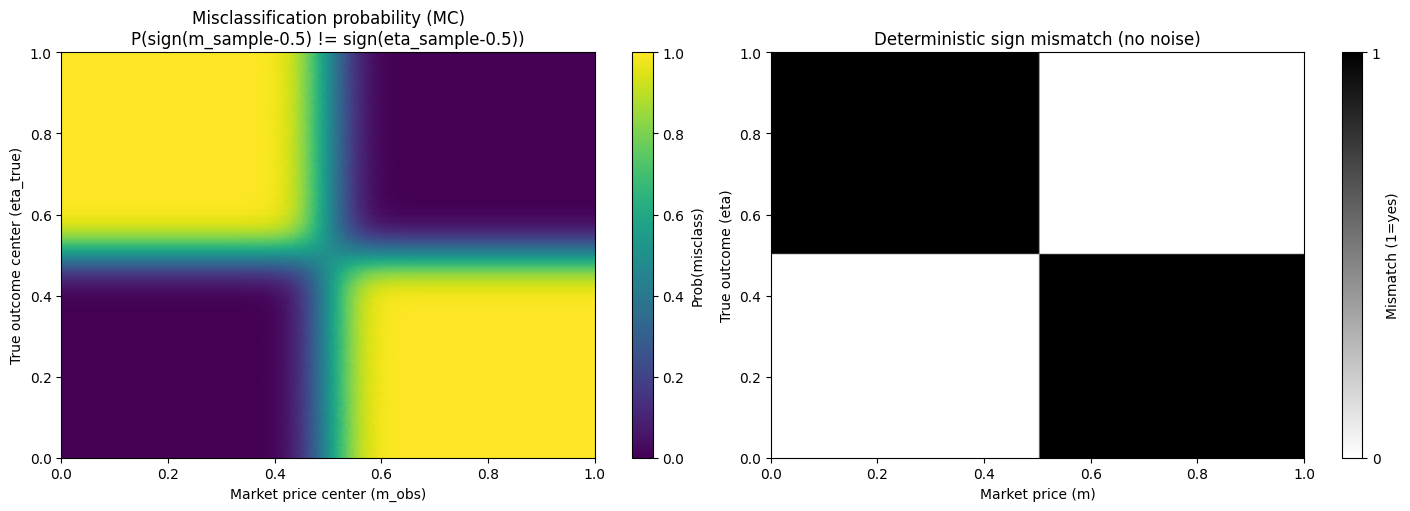

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange  # nice progress bar, optional
import math

# -----------------------------
# Parameters (tune as you like)
# -----------------------------
sigma_eta = 0.05   # uncertainty / noise around the true outcome
sigma_m   = 0.05   # uncertainty / noise around the observed market price
n_grid    = 201    # grid resolution (201x201)
mc_draws  = 5000   # Monte Carlo draws per grid cell (increase for smoother estimates)
rng = np.random.default_rng(42)

# -----------------------------
# Grid (y = true outcome, x = market price)
# -----------------------------
etas = np.linspace(0.0, 1.0, n_grid)   # y-axis
ms   = np.linspace(0.0, 1.0, n_grid)   # x-axis

# Pre-allocate result
misclf = np.zeros((n_grid, n_grid), dtype=float)  # rows: eta, cols: m

# -----------------------------
# Monte Carlo estimation
# -----------------------------
# We'll vectorize by drawing mc_draws samples at once per grid cell inside the loops.
for i_eta in range(n_grid):
    eta_center = etas[i_eta]
    # pre-draw eta samples for this center (mc_draws)
    eta_samples = rng.normal(loc=eta_center, scale=sigma_eta, size=mc_draws)
    # compute sign relative to 0.5 once
    sign_eta = (eta_samples > 0.5).astype(int)  # 1 means >0.5, 0 means <=0.5
    
    for j_m in range(n_grid):
        m_center = ms[j_m]
        # draw market samples
        m_samples = rng.normal(loc=m_center, scale=sigma_m, size=mc_draws)
        sign_m = (m_samples > 0.5).astype(int)
        # misclassification occurs when signs differ
        mismatch = (sign_m != sign_eta)
        misclf[i_eta, j_m] = mismatch.mean()

# -----------------------------
# Deterministic mask: sign mismatch without noise
# -----------------------------
# mask[i,j] = 1 if sign(m_j - 0.5) != sign(eta_i - 0.5)
sign_eta_grid = (etas > 0.5).astype(int)[:, None]   # shape (n_grid, 1)
sign_m_grid   = (ms > 0.5).astype(int)[None, :]     # shape (1, n_grid)
det_mask = (sign_eta_grid != sign_m_grid).astype(float)

# -----------------------------
# Plotting
# -----------------------------
fig, axs = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)

# Heatmap: Monte Carlo misclassification probability
ax = axs[0]
im = ax.imshow(
    misclf,
    origin='lower',
    extent=[ms.min(), ms.max(), etas.min(), etas.max()],
    aspect='auto',
    cmap='viridis',
    vmin=0.0, vmax=1.0
)
ax.set_title('Misclassification probability (MC)\nP(sign(m_sample-0.5) != sign(eta_sample-0.5))')
ax.set_xlabel('Market price center (m_obs)')
ax.set_ylabel('True outcome center (eta_true)')
fig.colorbar(im, ax=ax, label='Prob(misclass)')

# Heatmap: deterministic mask (for reference)
ax2 = axs[1]
im2 = ax2.imshow(
    det_mask,
    origin='lower',
    extent=[ms.min(), ms.max(), etas.min(), etas.max()],
    aspect='auto',
    cmap='gray_r'
)
ax2.set_title('Deterministic sign mismatch (no noise)')
ax2.set_xlabel('Market price (m)')
ax2.set_ylabel('True outcome (eta)')
fig.colorbar(im2, ax=ax2, ticks=[0,1], label='Mismatch (1=yes)')

plt.show()


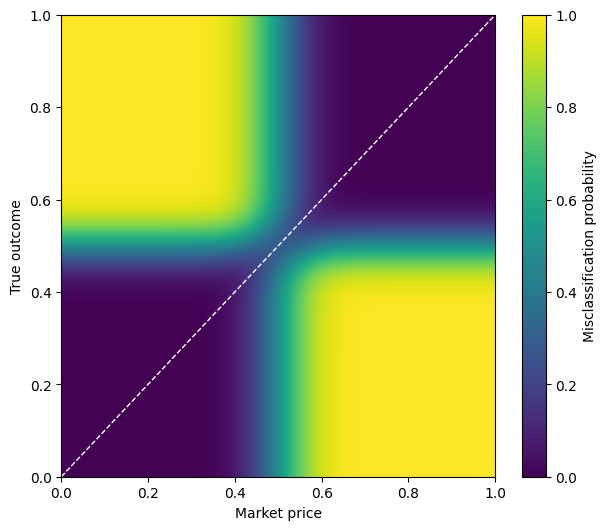

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

def misclassification_prob(mu_m, mu_eta, sigma_m, sigma_eta, rho):
    """
    Compute P((m-0.5)(eta-0.5) < 0) for (m,eta) ~ bivariate normal
    with means mu_m, mu_eta; std devs sigma_m, sigma_eta; correlation rho.
    """
    # Standardised thresholds
    a = (0.5 - mu_m) / sigma_m
    b = (0.5 - mu_eta) / sigma_eta
    
    # Univariate cdfs
    Phi_a = norm.cdf(a)
    Phi_b = norm.cdf(b)
    
    # Bivariate CDF at (a,b) with correlation rho
    # multivariate_normal.cdf gives P(X <= a, Y <= b) for mean=0 cov with corr rho.
    cov = np.array([[1.0, rho], [rho, 1.0]])
    # Note: multivariate_normal.cdf accepts array_like inputs; do scalar call:
    Phi2_ab = multivariate_normal.cdf([a, b], mean=[0.0, 0.0], cov=cov)
    
    # formula
    p = Phi_a + Phi_b - 2.0 * Phi2_ab
    return p

# ----------------------------
# Parameters and grid
# ----------------------------
sigma_m = 0.07     # std dev of market price
sigma_eta = 0.05   # std dev of true outcome (uncertainty)
rho = 0.6          # correlation between m and eta (choose 0..1)
n = 201

mu_m_grid = np.linspace(0.0, 1.0, n)     # x-axis (market price centers)
mu_eta_grid = np.linspace(0.0, 1.0, n)   # y-axis (true outcome centers)

P = np.zeros((n, n))
for i, mu_eta in enumerate(mu_eta_grid):
    for j, mu_m in enumerate(mu_m_grid):
        P[i, j] = misclassification_prob(mu_m, mu_eta, sigma_m, sigma_eta, rho)

# ----------------------------
# Plot heatmap
# ----------------------------
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(
    P,
    origin='lower',
    extent=[mu_m_grid[0], mu_m_grid[-1], mu_eta_grid[0], mu_eta_grid[-1]],
    aspect='auto',
    cmap='viridis',
    vmin=0, vmax=1
)
ax.set_xlabel('Market price')
ax.set_ylabel('True outcome')
# ax.set_title('P((m-0.5)(\\eta-0.5) < 0) (misclassification probability)')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Misclassification probability')
# Add diagonal reference line where mu_m = mu_eta
ax.plot([0,1],[0,1], color='white', linestyle='--', linewidth=1)
plt.savefig('misclassification_prob_heatmap.pdf')
